# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-07-21 11:36:55,229] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

The code below will run the simulation

In [3]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [5]:
env.close()

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As shown before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is the implementation of the Q-network. We used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initializing the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. 

In [12]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 9.0 Training loss: 1.0849 Explore P: 0.9991
Episode: 2 Total reward: 58.0 Training loss: 0.9822 Explore P: 0.9934
Episode: 3 Total reward: 14.0 Training loss: 1.0723 Explore P: 0.9920
Episode: 4 Total reward: 20.0 Training loss: 1.0979 Explore P: 0.9901
Episode: 5 Total reward: 32.0 Training loss: 1.0356 Explore P: 0.9869
Episode: 6 Total reward: 37.0 Training loss: 1.1664 Explore P: 0.9833
Episode: 7 Total reward: 14.0 Training loss: 1.2208 Explore P: 0.9820
Episode: 8 Total reward: 10.0 Training loss: 1.2882 Explore P: 0.9810
Episode: 9 Total reward: 42.0 Training loss: 1.2437 Explore P: 0.9769
Episode: 10 Total reward: 52.0 Training loss: 1.6007 Explore P: 0.9719
Episode: 11 Total reward: 19.0 Training loss: 1.4394 Explore P: 0.9701
Episode: 12 Total reward: 17.0 Training loss: 3.2893 Explore P: 0.9684
Episode: 13 Total reward: 13.0 Training loss: 1.8067 Explore P: 0.9672
Episode: 14 Total reward: 20.0 Training loss: 2.7598 Explore P: 0.9653
Episode: 15 Tota

Episode: 117 Total reward: 16.0 Training loss: 136.5871 Explore P: 0.7836
Episode: 118 Total reward: 17.0 Training loss: 393.8699 Explore P: 0.7823
Episode: 119 Total reward: 30.0 Training loss: 6.1902 Explore P: 0.7800
Episode: 120 Total reward: 10.0 Training loss: 6.4477 Explore P: 0.7792
Episode: 121 Total reward: 22.0 Training loss: 171.2109 Explore P: 0.7776
Episode: 122 Total reward: 18.0 Training loss: 6.8763 Explore P: 0.7762
Episode: 123 Total reward: 11.0 Training loss: 495.9520 Explore P: 0.7753
Episode: 124 Total reward: 22.0 Training loss: 4.4383 Explore P: 0.7736
Episode: 125 Total reward: 21.0 Training loss: 151.6802 Explore P: 0.7720
Episode: 126 Total reward: 34.0 Training loss: 5.7058 Explore P: 0.7695
Episode: 127 Total reward: 10.0 Training loss: 5.9175 Explore P: 0.7687
Episode: 128 Total reward: 12.0 Training loss: 360.3036 Explore P: 0.7678
Episode: 129 Total reward: 27.0 Training loss: 134.5872 Explore P: 0.7657
Episode: 130 Total reward: 11.0 Training loss: 3.7

Episode: 230 Total reward: 16.0 Training loss: 95.3639 Explore P: 0.6491
Episode: 231 Total reward: 14.0 Training loss: 111.6904 Explore P: 0.6482
Episode: 232 Total reward: 16.0 Training loss: 1.7138 Explore P: 0.6471
Episode: 233 Total reward: 11.0 Training loss: 186.0417 Explore P: 0.6464
Episode: 234 Total reward: 14.0 Training loss: 228.1894 Explore P: 0.6456
Episode: 235 Total reward: 19.0 Training loss: 94.7607 Explore P: 0.6444
Episode: 236 Total reward: 17.0 Training loss: 5.5352 Explore P: 0.6433
Episode: 237 Total reward: 19.0 Training loss: 95.1615 Explore P: 0.6421
Episode: 238 Total reward: 13.0 Training loss: 121.6055 Explore P: 0.6413
Episode: 239 Total reward: 14.0 Training loss: 65.2912 Explore P: 0.6404
Episode: 240 Total reward: 11.0 Training loss: 103.1014 Explore P: 0.6397
Episode: 241 Total reward: 27.0 Training loss: 32.6985 Explore P: 0.6380
Episode: 242 Total reward: 11.0 Training loss: 31.3012 Explore P: 0.6373
Episode: 243 Total reward: 13.0 Training loss: 1

Episode: 343 Total reward: 56.0 Training loss: 21.7139 Explore P: 0.5353
Episode: 344 Total reward: 27.0 Training loss: 22.9360 Explore P: 0.5338
Episode: 345 Total reward: 24.0 Training loss: 36.5083 Explore P: 0.5326
Episode: 346 Total reward: 62.0 Training loss: 20.4062 Explore P: 0.5294
Episode: 347 Total reward: 14.0 Training loss: 33.4084 Explore P: 0.5286
Episode: 348 Total reward: 54.0 Training loss: 1.0783 Explore P: 0.5258
Episode: 349 Total reward: 111.0 Training loss: 17.1727 Explore P: 0.5202
Episode: 350 Total reward: 42.0 Training loss: 26.2750 Explore P: 0.5180
Episode: 351 Total reward: 35.0 Training loss: 47.3170 Explore P: 0.5162
Episode: 352 Total reward: 63.0 Training loss: 1.3303 Explore P: 0.5131
Episode: 353 Total reward: 33.0 Training loss: 1.2061 Explore P: 0.5114
Episode: 354 Total reward: 78.0 Training loss: 32.3206 Explore P: 0.5075
Episode: 355 Total reward: 35.0 Training loss: 1.2546 Explore P: 0.5058
Episode: 356 Total reward: 42.0 Training loss: 31.0034

Episode: 456 Total reward: 67.0 Training loss: 73.0722 Explore P: 0.2760
Episode: 457 Total reward: 73.0 Training loss: 2.4522 Explore P: 0.2741
Episode: 458 Total reward: 53.0 Training loss: 9.4655 Explore P: 0.2727
Episode: 459 Total reward: 55.0 Training loss: 1.7375 Explore P: 0.2712
Episode: 460 Total reward: 32.0 Training loss: 18.3602 Explore P: 0.2704
Episode: 461 Total reward: 61.0 Training loss: 1.2453 Explore P: 0.2688
Episode: 462 Total reward: 42.0 Training loss: 3.4171 Explore P: 0.2677
Episode: 463 Total reward: 53.0 Training loss: 2.0454 Explore P: 0.2664
Episode: 464 Total reward: 39.0 Training loss: 58.8861 Explore P: 0.2654
Episode: 465 Total reward: 78.0 Training loss: 1.0491 Explore P: 0.2634
Episode: 466 Total reward: 43.0 Training loss: 8.5220 Explore P: 0.2623
Episode: 467 Total reward: 46.0 Training loss: 6.3144 Explore P: 0.2611
Episode: 468 Total reward: 31.0 Training loss: 3.7266 Explore P: 0.2604
Episode: 469 Total reward: 105.0 Training loss: 0.8771 Explor

Episode: 569 Total reward: 61.0 Training loss: 1.9886 Explore P: 0.1166
Episode: 570 Total reward: 87.0 Training loss: 165.4488 Explore P: 0.1157
Episode: 571 Total reward: 86.0 Training loss: 2.9883 Explore P: 0.1148
Episode: 572 Total reward: 83.0 Training loss: 0.3631 Explore P: 0.1139
Episode: 573 Total reward: 62.0 Training loss: 2.6304 Explore P: 0.1133
Episode: 574 Total reward: 67.0 Training loss: 2.5235 Explore P: 0.1126
Episode: 575 Total reward: 49.0 Training loss: 1.0026 Explore P: 0.1121
Episode: 576 Total reward: 65.0 Training loss: 238.4544 Explore P: 0.1114
Episode: 577 Total reward: 60.0 Training loss: 2.2588 Explore P: 0.1108
Episode: 578 Total reward: 47.0 Training loss: 3.0593 Explore P: 0.1104
Episode: 579 Total reward: 62.0 Training loss: 3.3334 Explore P: 0.1097
Episode: 580 Total reward: 78.0 Training loss: 1.8944 Explore P: 0.1090
Episode: 581 Total reward: 49.0 Training loss: 1.2357 Explore P: 0.1085
Episode: 582 Total reward: 57.0 Training loss: 3.0200 Explor

Episode: 683 Total reward: 199.0 Training loss: 0.3919 Explore P: 0.0448
Episode: 684 Total reward: 199.0 Training loss: 0.1460 Explore P: 0.0441
Episode: 685 Total reward: 199.0 Training loss: 0.3047 Explore P: 0.0435
Episode: 686 Total reward: 199.0 Training loss: 0.3910 Explore P: 0.0428
Episode: 687 Total reward: 199.0 Training loss: 0.2477 Explore P: 0.0421
Episode: 688 Total reward: 199.0 Training loss: 0.2663 Explore P: 0.0415
Episode: 689 Total reward: 199.0 Training loss: 0.4056 Explore P: 0.0409
Episode: 690 Total reward: 199.0 Training loss: 23.0460 Explore P: 0.0403
Episode: 691 Total reward: 199.0 Training loss: 0.2400 Explore P: 0.0397
Episode: 692 Total reward: 119.0 Training loss: 0.3975 Explore P: 0.0393
Episode: 693 Total reward: 199.0 Training loss: 0.9879 Explore P: 0.0388
Episode: 694 Total reward: 109.0 Training loss: 0.6030 Explore P: 0.0384
Episode: 695 Total reward: 99.0 Training loss: 0.5062 Explore P: 0.0382
Episode: 696 Total reward: 95.0 Training loss: 0.49

Episode: 796 Total reward: 199.0 Training loss: 0.5888 Explore P: 0.0148
Episode: 797 Total reward: 199.0 Training loss: 0.3694 Explore P: 0.0147
Episode: 798 Total reward: 199.0 Training loss: 0.3776 Explore P: 0.0146
Episode: 799 Total reward: 199.0 Training loss: 0.2623 Explore P: 0.0146
Episode: 800 Total reward: 199.0 Training loss: 0.1572 Explore P: 0.0145
Episode: 801 Total reward: 199.0 Training loss: 0.2843 Explore P: 0.0144
Episode: 802 Total reward: 199.0 Training loss: 0.1519 Explore P: 0.0143
Episode: 803 Total reward: 199.0 Training loss: 0.1480 Explore P: 0.0142
Episode: 804 Total reward: 199.0 Training loss: 0.2178 Explore P: 0.0141
Episode: 805 Total reward: 199.0 Training loss: 0.3258 Explore P: 0.0140
Episode: 806 Total reward: 199.0 Training loss: 0.1914 Explore P: 0.0140
Episode: 807 Total reward: 199.0 Training loss: 0.2551 Explore P: 0.0139
Episode: 808 Total reward: 199.0 Training loss: 0.2058 Explore P: 0.0138
Episode: 809 Total reward: 199.0 Training loss: 0.1

Episode: 909 Total reward: 199.0 Training loss: 0.2544 Explore P: 0.0108
Episode: 910 Total reward: 199.0 Training loss: 0.2985 Explore P: 0.0108
Episode: 911 Total reward: 199.0 Training loss: 0.1460 Explore P: 0.0108
Episode: 912 Total reward: 199.0 Training loss: 0.5531 Explore P: 0.0108
Episode: 913 Total reward: 199.0 Training loss: 0.2470 Explore P: 0.0108
Episode: 914 Total reward: 199.0 Training loss: 0.3846 Explore P: 0.0108
Episode: 915 Total reward: 199.0 Training loss: 0.6616 Explore P: 0.0107
Episode: 916 Total reward: 199.0 Training loss: 0.7104 Explore P: 0.0107
Episode: 917 Total reward: 199.0 Training loss: 189.0901 Explore P: 0.0107
Episode: 918 Total reward: 199.0 Training loss: 0.7943 Explore P: 0.0107
Episode: 919 Total reward: 199.0 Training loss: 0.8905 Explore P: 0.0107
Episode: 920 Total reward: 163.0 Training loss: 1.1946 Explore P: 0.0107
Episode: 921 Total reward: 104.0 Training loss: 0.7247 Explore P: 0.0107
Episode: 922 Total reward: 70.0 Training loss: 25

In [13]:
env.close()

## Visualizing training

Below we plot the total rewards for each episode. We are plotting the rolling average too, in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

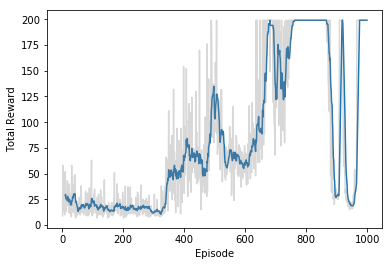

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [16]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [17]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.